# Álgebra Linear para Ciência de Dados
## Seminário 2 - Nonlinear least squares

### Desafios

#### Problema 1: exercício 18.6 do VMLS

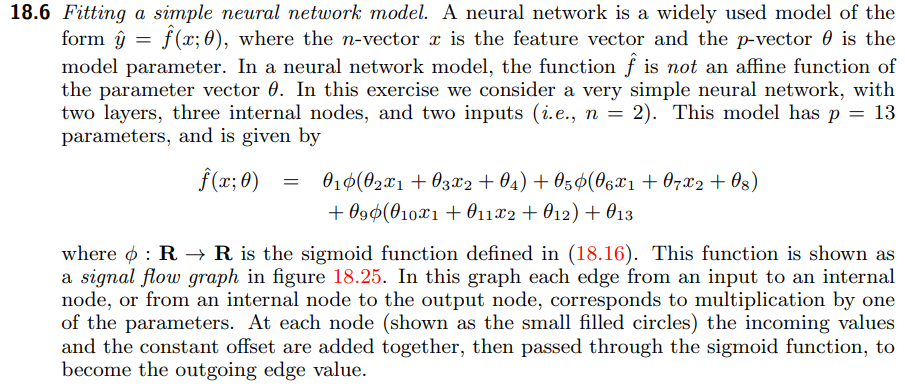
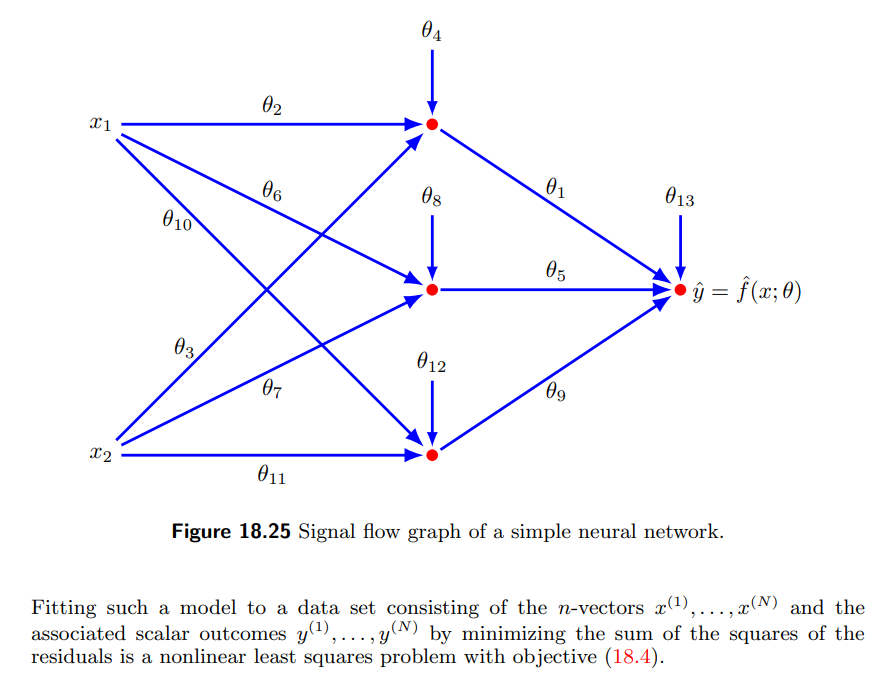

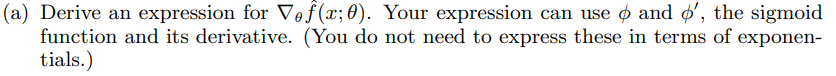

$$\hat{f}(x; \theta) = \theta_1 \phi(\theta_2 x_1 + \theta_3 x_2 + \theta_4) 
+ \theta_5 \phi(\theta_6 x_1 + \theta_7 x_2 + \theta_8) 
+ \theta_9 \phi(\theta_{10} x_1 + \theta_{11} x_2 + \theta_{12}) 
+ \theta_{13}$$

$$
\frac{\partial \hat{f}}{\partial \theta_1}
= 
\phi(\theta_2 x_1 + \theta_3 x_2 + \theta_4)
$$

Pela regra da cadeia
$$
\frac{\partial \hat{f}}{\partial \theta_2}
= 
\theta_1 \phi'(\theta_2 x_1 + \theta_3 x_2 + \theta_4)
\cdot
x_1
$$

$$
\frac{\partial \hat{f}}{\partial \theta_3}
= 
\theta_1 \phi'(\theta_2 x_1 + \theta_3 x_2 + \theta_4)
\cdot
x_2
$$

$$
\frac{\partial \hat{f}}{\partial \theta_4}
= 
\theta_1 \phi'(\theta_2 x_1 + \theta_3 x_2 + \theta_4)
$$

(processo semelhante para todos os outros)

$$
\nabla_\theta \hat{f}(x; \theta)
=
\begin{bmatrix}
    \phi(\theta_2 x_1 + \theta_3 x_2 + \theta_4) \\
    \theta_1 \phi'(\theta_2 x_1 + \theta_3 x_2 + \theta_4) x_1 \\
    \theta_1 \phi'(\theta_2 x_1 + \theta_3 x_2 + \theta_4) x_2 \\
    \theta_1 \phi'(\theta_2 x_1 + \theta_3 x_2 + \theta_4) \\
    \phi(\theta_6 x_1 + \theta_7 x_2 + \theta_8) \\
    \theta_5 \phi'(\theta_6 x_1 + \theta_7 x_2 + \theta_8) x_1 \\
    \theta_5 \phi'(\theta_6 x_1 + \theta_7 x_2 + \theta_8) x_2 \\
    \theta_5 \phi'(\theta_6 x_1 + \theta_7 x_2 + \theta_8) \\
    \phi(\theta_{10} x_1 + \theta_{11} x_2 + \theta_{12}) \\
    \theta_9 \phi'(\theta_{10} x_1 + \theta_{11} x_2 + \theta_{12}) x_1 \\
    \theta_9 \phi'(\theta_{10} x_1 + \theta_{11} x_2 + \theta_{12}) x_2 \\
    \theta_9 \phi'(\theta_{10} x_1 + \theta_{11} x_2 + \theta_{12})  \\
    1
\end{bmatrix},
$$

onde
$$
\phi(u) = \frac{e^u - e^{-u}}{e^u + e^{-u}}
\Rightarrow
\phi'(u) = \frac{4}{(e^x-e^{-x})^2}.
$$

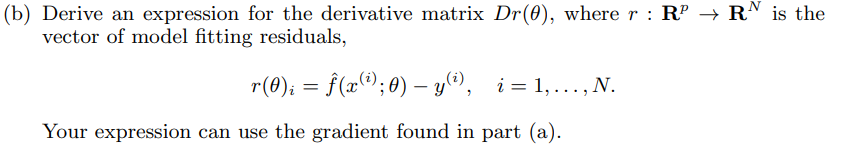

$$r(\theta)_i = \hat{f}(x^{(i)}\theta) - y^{(i)},
\ i = 1, \ldots, N$$

$$Dr(\theta)_i = \nabla_\theta \hat{f}(x^{(i)}\theta)^T,
\ i = 1, \ldots, N$$.

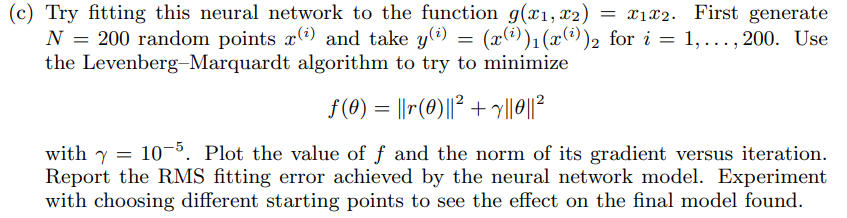

Antes de tudo, vamos relembrar o algoritmo de Levenberg-Marquardt.

In [321]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression

In [301]:
def lm(f, Df, x_ini, lam, tol=1e-6, k_max=100) -> np.ndarray:
    """
    Algoritmo de Levenberg-Marquardt para mínimos quadrados não-linear.

    Parâmetros:
    ----------
    f : function
        Função objetivo que retorna o vetor de resíduos. Deve ser vetorizada.
    Df : function
        Função que calcula a Jacobiana da função objetivo `f`.
    x_ini : numpy.ndarray
        Estimativa inicial para os parâmetros a serem otimizados.
    lam : float
        Parâmetro de amortecimento inicial que controla a magnitude da regularização.
    tol : float, opcional (default=1e-6)
        Critério de convergência com base na norma do gradiente.
    k_max : int, opcional (default=100)
        Número máximo de iterações.

    Retorna:
    -------
    xk : numpy.ndarray
        Vetor de parâmetros otimizados.
    """

    xk = x_ini.copy()

    k = 0
    fxks = []
    gradnorms = []
    while (np.linalg.norm(f(xk)) >= tol) and (np.linalg.norm(2 * Df(xk).T @ f(xk)) >= tol) and (k < k_max):
        fxks.append(np.linalg.norm(f(xk)))
        gradnorms.append(np.linalg.norm(2 * Df(xk).T @ f(xk)))
        J = Df(xk)
        H = J.T @ J
        g = J.T @ f(xk)

        p = np.linalg.inv(H + lam * np.eye(H.shape[0]))
        p = p @ g

        x_next = xk - p

        k += 1

        if np.linalg.norm(f(x_next)) < np.linalg.norm(f(xk)):
            lam = 0.8 * lam
            xk = x_next
            continue

        lam = 2 * lam
        # não atualiza xk

    return xk, k, fxks, gradnorms


Vamos gerar os $N = 200$ pontos $x^{(i)}$, aleatoriamente.

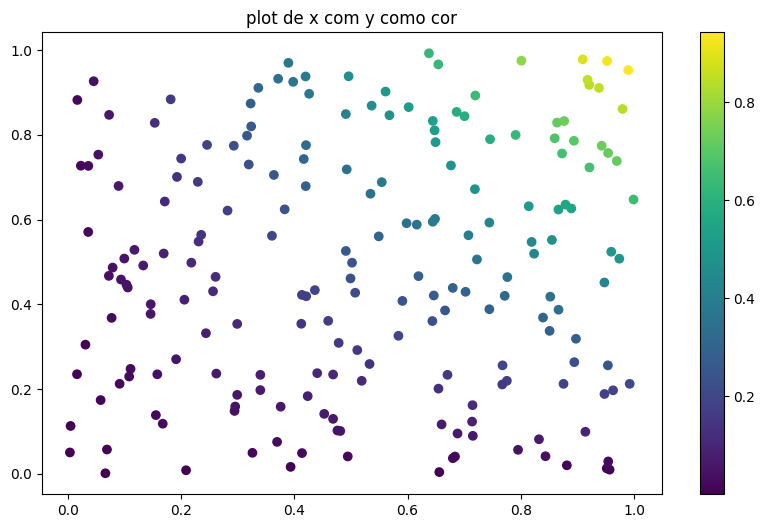

In [302]:
np.random.seed(666)
# gerando x
data_x = np.random.rand(200, 2)
# g(x1, x2) = x1 * x2 = y
y = data_x[:, 0] * data_x[:, 1]
# plot x, y como cor
plt.figure(figsize=(10, 6))
plt.title('plot de x com y como cor')
plt.scatter(data_x[:, 0], data_x[:, 1], c=y)
plt.colorbar()
plt.show()

Já temos tudo, basicamente, definido.

Nossa função objetivo é o resíduo $r(\theta) = \hat{f}(x; \theta) - y$ dado pelo problema. A Jacobiana é $Dr(\theta)$, calculada em (b).

Basta, apenas, definirmos tudo isso no código.

In [303]:
# função sigmoide e sua derivada
def sigmoid(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

def Dsigmoid(x):
    return 4 / (np.exp(x) + np.exp(-x))**2

# função objetivo
def f_hat(x, theta):
    return (
        theta[0] * sigmoid(theta[1] * x[0] + theta[2] * x[1] + theta[3])
        + theta[4] * sigmoid(theta[5] * x[0] + theta[6] * x[1] + theta[7])
        + theta[8] * sigmoid(theta[9] * x[0] + theta[10] * x[1] + theta[11])
        + theta[12]
    )

#r = lambda theta: f_hat(theta) - y

def r(theta):
    return np.array([f_hat(data_x[i], theta) - y[i] for i in range(len(y))])

# Função Dr(theta)
def Dr_base(x, theta):
    z1 = theta[1] * x[0] + theta[2] * x[1] + theta[3]  # θ2*x1 + θ3*x2 + θ4
    z2 = theta[5] * x[0] + theta[6] * x[1] + theta[7]  # θ6*x1 + θ7*x2 + θ8
    z3 = theta[9] * x[0] + theta[10] * x[1] + theta[11]  # θ10*x1 + θ11*x2 + θ12

    # Calcula as derivadas e funções sigmoide
    phi1 = sigmoid(z1)
    Dphi1 = Dsigmoid(z1)
    phi2 = sigmoid(z2)
    Dphi2 = Dsigmoid(z2)
    phi3 = sigmoid(z3)
    Dphi3 = Dsigmoid(z3)

    # Constrói o gradiente como uma matriz coluna
    return np.column_stack([
        [phi1],                            # φ(θ2*x1 + θ3*x2 + θ4)
        [theta[0] * Dphi1 * x[0]],         # θ1 * φ'(θ2*x1 + θ3*x2 + θ4) * x1
        [theta[0] * Dphi1 * x[1]],         # θ1 * φ'(θ2*x1 + θ3*x2 + θ4) * x2
        [theta[0] * Dphi1],                # θ1 * φ'(θ2*x1 + θ3*x2 + θ4)
        [phi2],                            # φ(θ6*x1 + θ7*x2 + θ8)
        [theta[4] * Dphi2 * x[0]],         # θ5 * φ'(θ6*x1 + θ7*x2 + θ8) * x1
        [theta[4] * Dphi2 * x[1]],         # θ5 * φ'(θ6*x1 + θ7*x2 + θ8) * x2
        [theta[4] * Dphi2],                # θ5 * φ'(θ6*x1 + θ7*x2 + θ8)
        [phi3],                            # φ(θ10*x1 + θ11*x2 + θ12)
        [theta[8] * Dphi3 * x[0]],         # θ9 * φ'(θ10*x1 + θ11*x2 + θ12) * x1
        [theta[8] * Dphi3 * x[1]],         # θ9 * φ'(θ10*x1 + θ11*x2 + θ12) * x2
        [theta[8] * Dphi3],                # θ9 * φ'(θ10*x1 + θ11*x2 + θ12)
        [1]                                # Constante 1
    ])

def Dr(theta):
    return np.vstack([Dr_base(data_x[i], theta) for i in range(len(y))])

Usaremos $\theta_{\text{inicial}}$ aleatório (como usual com redes neurais) e o $\lambda = \gamma = 10^{-5}$ dado pelo exercício.

In [304]:
np.random.seed(666)

theta_ini = np.random.rand(13)

gamma = 1e-5

theta_opt, n_iter, fxks, gradnorms = lm(r, Dr, theta_ini, gamma, k_max=1000)

In [305]:
theta_opt, n_iter

(array([-18.26174745,  -0.21942921,  -0.21341995,   0.88483316,
         19.9745711 ,  -0.20535555,   0.07502169,   0.71085761,
         25.7272853 ,   0.03434401,  -0.16703977,   0.65870833,
        -14.12381035]),
 1000)

Plotando o valor de $f$ e a norma de seu gradiente conforme as iterações.

In [306]:
fxks = np.array(fxks)
gradnorms = np.array(gradnorms)
fxks.shape, gradnorms.shape

((1000,), (1000,))

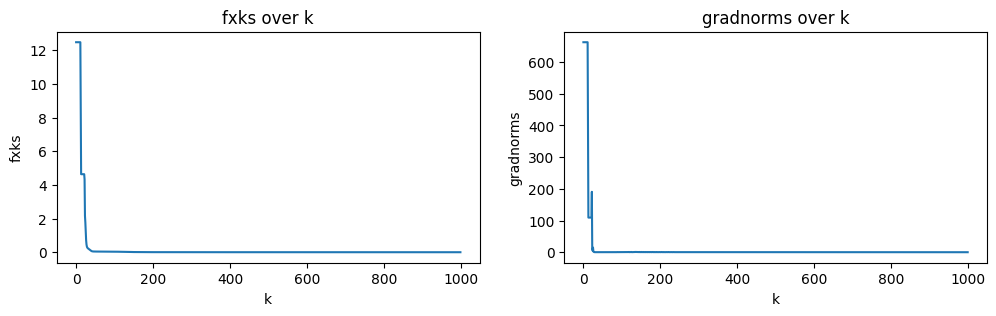

In [312]:
# plot fxks over k, and gradnorms over k, side by side
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.plot(fxks)
plt.title('fxks over k')
plt.xlabel('k')
plt.ylabel('fxks')
plt.subplot(1, 2, 2)
plt.plot(gradnorms)
plt.title('gradnorms over k')
plt.xlabel('k')
plt.ylabel('gradnorms')
plt.show()

Vemos que a otimização se encerrou após atingir o número máximo de iterações, e não por critério de convergência.

Contudo, podemos ainda assim ter obtido um bom resultado caso o processo estivesse caminhando para convergência.

In [318]:
y_pred = np.array([f_hat(data_x[i], theta_opt) for i in range(len(y))])
rmse = root_mean_squared_error(y, y_pred)
print(rmse)

0.00028287211464802137


Um erro baixíssimo, dentro do esperado!

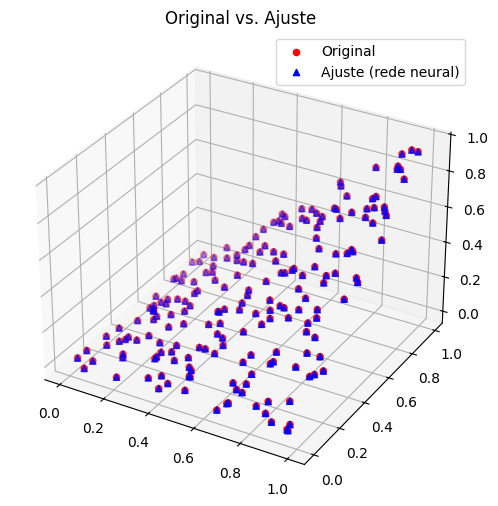

In [309]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Original vs. Ajuste')
ax.scatter(data_x[:, 0], data_x[:, 1], y, c='r', marker='o', label='Original')
ax.scatter(data_x[:, 0], data_x[:, 1], f_hat(data_x.T, theta_opt), c='b', marker='^', label='Ajuste (rede neural)')
ax.legend()
plt.show()

Parece adequado. Comparemos a $\hat{f}(x; \theta)$ obtida com $g(x) = x_1x_2$.

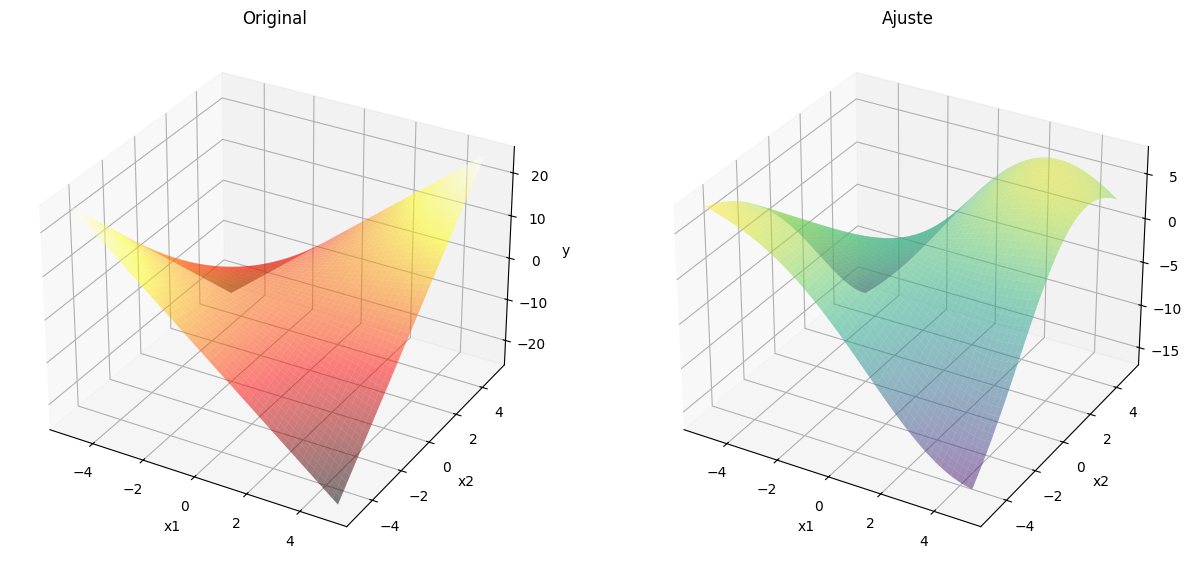

In [310]:
# f_hat vs g, side by side

x1  = np.linspace(-5, 5, 1000)
x2 = np.linspace(-5, 5, 1000)

X1, X2 = np.meshgrid(x1, x2)
G = X1 * X2
Y = f_hat([X1, X2], theta_opt)

fig, ax = plt.subplots(1, 2, figsize=(15, 7), subplot_kw={'projection': '3d'})
ax[0].plot_surface(X1, X2, G, alpha=0.5, cmap='hot')
ax[0].set_title('Original')
ax[0].set_xlabel('x1')
ax[0].set_ylabel('x2')
ax[0].set_zlabel('y')

ax[1].plot_surface(X1, X2, Y, alpha=0.5, cmap='viridis')
ax[1].set_title('Ajuste')
ax[1].set_xlabel('x1')
ax[1].set_ylabel('x2')
ax[1].set_zlabel('y')

plt.show()

**Nota:** mexa no intervalo de x e veja a situação mudar. Vemos um possível caso de overfitting (?)

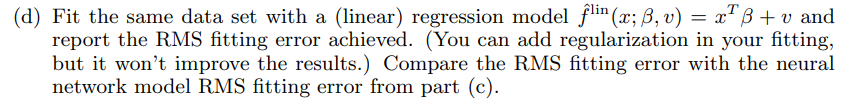

In [322]:
model = LinearRegression()
model.fit(data_x, y)
y_pred_lin = model.predict(data_x)

In [323]:
linear_rms = root_mean_squared_error(y, y_pred_lin)
linear_rms

np.float64(0.0846388703655821)

**Problemas:**
* regularização
* refazer linear